In [4]:
import sys
sys.path.append(r'../')
#import mat73
import numpy as np
from functions import *
'''from tqdm import tqdm
from scipy import signal
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.animation as animation

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
'''
%reload_ext autoreload
%autoreload 2
from functions import *

In [3]:
### Load Data (and excluding behavioural neurons)
worm_num = 4
b_neurons = [
    'AVAR',
    'AVAL',
    'SMDVR',
    'SMDVL',
    'SMDDR',
    'SMDDL',
    'RIBR',
    'RIBL',]
data = Database(data_set_no=worm_num)
data.exclude_neurons(b_neurons)
X = data.neuron_traces.T
B = data.states

### Preprocess and prepare data for BundLe Net
time, X = preprocess_data(X, data.fps)
X_, B_ = prep_data(X, B, win=15)

### Deploy BunDLe Net
model = BunDLeNet(latent_dim=3)
model.build(input_shape=X_.shape)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

n_epochs = 1000
gamma = 0.9

#X_train, X_test, B_train, B_test = timeseries_train_test_split(X_, B_)
loss_array = train_model(X_, B_, model, optimizer, gamma, n_epochs, pca_init=True)

2023-06-05 17:23:37.108075: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-06-05 17:23:37.108131: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: akshey-System-Product-Name
2023-06-05 17:23:37.108145: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: akshey-System-Product-Name
2023-06-05 17:23:37.108283: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.182.3
2023-06-05 17:23:37.108331: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-06-05 17:23:37.108344: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.161.3 does not match DSO version 470.182.3 -- cannot find working devices in this configuration
2023-06-05 17:23:37.108677: I tensorflow/core/platform/c

KeyboardInterrupt: 

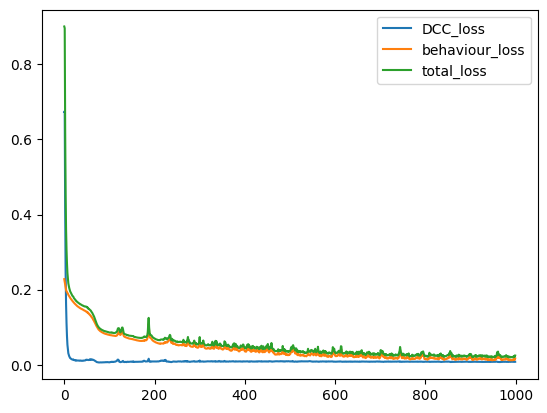

In [3]:
# Training losses vs epochs
%matplotlib inline
for i, label in  enumerate(["DCC_loss", "behaviour_loss","total_loss" ]):
    plt.plot(loss_array[:,i], label=label)
plt.legend()
#plt.ylim(0,.01)

### Projecting into latent space

In [4]:
Y0_ = model.tau(X_[:,0]).numpy() 

In [5]:
algorithm = 'BunDLeNet'
np.savetxt('Saved_Y/Y0__' + algorithm + '_worm_' + str(worm_num), Y0_)
np.savetxt('Saved_Y/B__' + algorithm + '_worm_' + str(worm_num), B_)

In [15]:
algorithm = 'BunDLeNet'
Y0_ = np.loadtxt('Saved_Y/Y0__' + algorithm + '_worm_' + str(worm_num))
B_ = np.loadtxt('Saved_Y/B__' + algorithm + '_worm_' + str(worm_num)).astype(int)

(0.0, 3006.0, -0.5, 0.5)

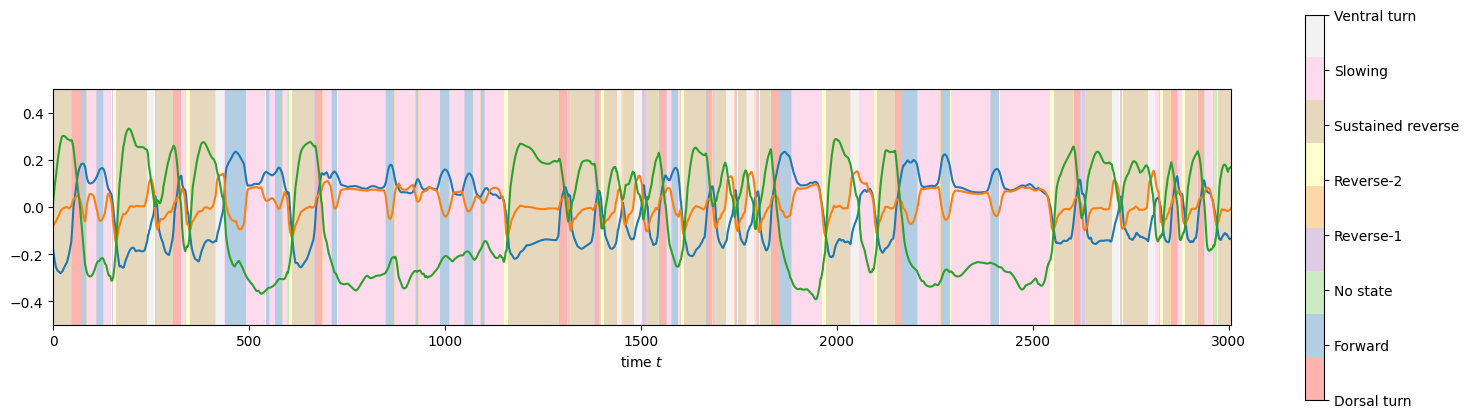

In [16]:
### Plotting latent space dynamics
%matplotlib inline
plt.figure(figsize=(19,5))
plt.imshow([B_],aspect=600,cmap="Pastel1")
cbar = plt.colorbar(ticks=np.arange(8))
cbar.ax.set_yticklabels(['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reverse', 'Slowing', 'Ventral turn']) 
plt.plot(Y0_/Y0_.max()/3)
plt.xlabel("time $t$")
plt.axis([0,Y0_.shape[0],-0.5,0.5])

<IPython.core.display.Javascript object>


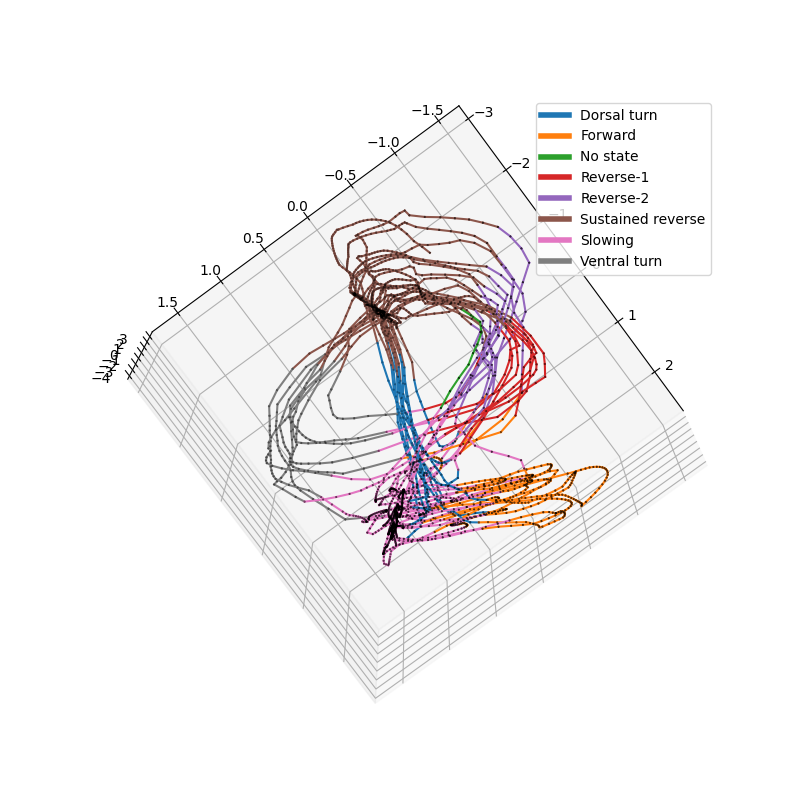

<Axes3DSubplot: >

In [14]:
%matplotlib notebook
plot_phase_space(Y0_, B_, show_points=True)

<IPython.core.display.Javascript object>


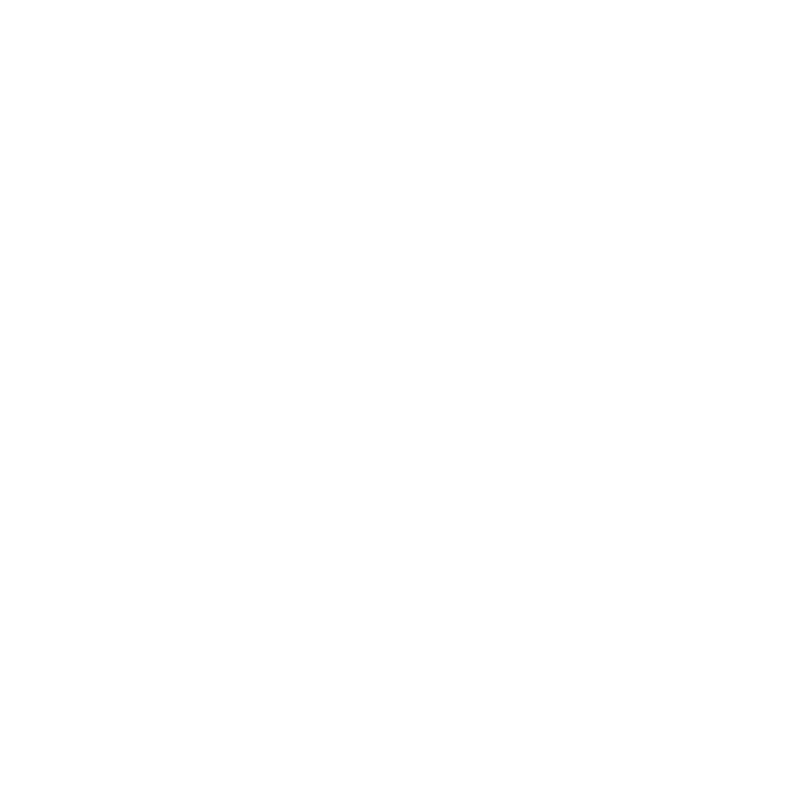

<Axes3DSubplot: >

In [9]:
### Run to produce rotating 3-D plot
%matplotlib notebook
rotating_plot(Y0_, B_,filename='rotation_'+ algorithm + '_worm_'+str(worm_num) +'.gif')

### Performing PCA on the latent dimension (to check if there are redundant or correlated components)


(0.0, 3006.0, -0.5, 0.5)

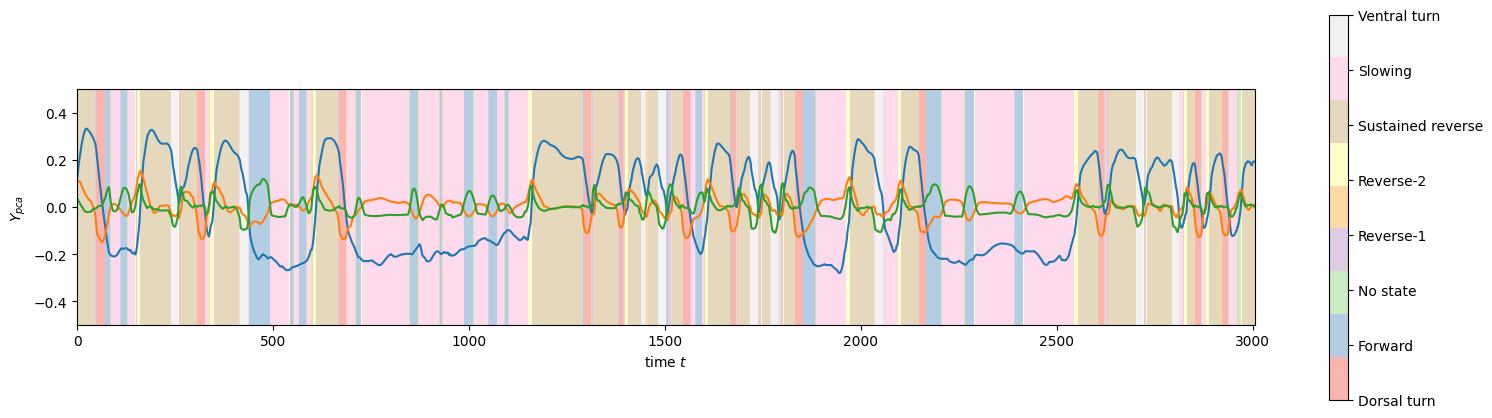

In [10]:
%matplotlib inline
pca = PCA()
Y_pca = pca.fit_transform(Y0_)
plt.figure(figsize=(19,5))
plt.imshow([B_],aspect=600,cmap="Pastel1")
cbar = plt.colorbar(ticks=np.arange(8))
cbar.ax.set_yticklabels(['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reverse', 'Slowing', 'Ventral turn']) 
plt.plot(Y_pca/Y_pca.max()/3)
plt.xlabel("time $t$")
plt.ylabel("$Y_{pca}$")
plt.axis([0,Y_pca.shape[0],-0.5,0.5])

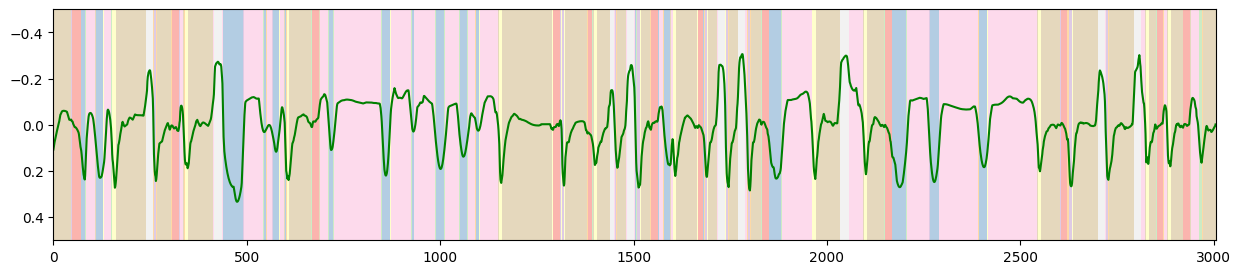

In [11]:
%matplotlib inline
plt.figure(figsize=(15,3))
plt.imshow([B_],aspect="auto",cmap="Pastel1")
plt.plot(Y_pca[:,2]/3/np.max(np.abs(Y_pca[:,2])), color = 'green')

### Behaviour predictor (implicit in the AbC net)


In [12]:
Y0_ = model.tau(X_[:,0]).numpy() # Y_t
Y1_ = model.tau(X_[:,1]).numpy()

In [13]:
B_pred = model.predictor(Y1_).numpy().argmax(axis=1)
accuracy_score(B_pred, B_)

0.928476380572189